In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import multivariate_normal
from plot_utils import plotContourNormal, Dirichlet, draw_pdf_contours, \
                       plotContourTruncatedNormal
import seaborn as sns
import tensorflow as tf
from efn_util import setup_IO, find_convergence, model_opt_hps, easy_inds
from tf_util.stat_util import drawPoissonCounts
from plot_util import exptrend, sattrend, load_V1_events, \
                      find_last_ind, get_latest_diagnostics, \
                      load_counts_spikes, cut_trailing_spikes, \
                      time_series_contour
import scipy.io as sio
from tf_util.families import family_from_str

import os

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

exp_fam = 'lgc';
D = 20;

wsize = 50;
delta_thresh = 1e-10;

basedir = '/Users/sbittner/Documents/efn/';
dir_str = exp_fam;

fam_class = family_from_str(exp_fam);
family = fam_class(D);

T_s = .02;
K = 100;
M = 200;
TIF_flow_type = 'PlanarFlowLayer'; 
nlayers = 30;
flow_dict = {'latent_dynamics':None, \
             'scale_layer':False, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers};
param_net_hps = {'L':5};
give_hint = False;
rs = 0;

2941 monkey 3, neuron 104, ori 2
nf /Users/sbittner/Documents/efn/results/lgc/NF1_log_gaussian_cox_D=20_flow=30P_ds=2941_rs=0/
MLE estimate
[0.13  0.235 0.225 0.22  0.185 0.15  0.15  0.11  0.135 0.23  0.185 0.16
 0.195 0.215 0.135 0.1   0.125 0.185 0.14  0.16 ]


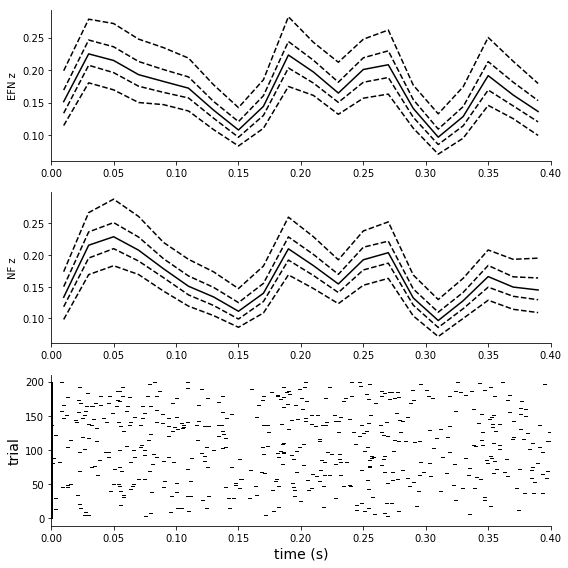

2539 monkey 3, neuron 70, ori 8
nf /Users/sbittner/Documents/efn/results/lgc/NF1_log_gaussian_cox_D=20_flow=30P_ds=2539_rs=0/
MLE estimate
[0.035 0.02  0.03  0.06  0.1   0.065 0.085 0.05  0.04  0.025 0.02  0.065
 0.06  0.085 0.04  0.065 0.04  0.06  0.055 0.06 ]


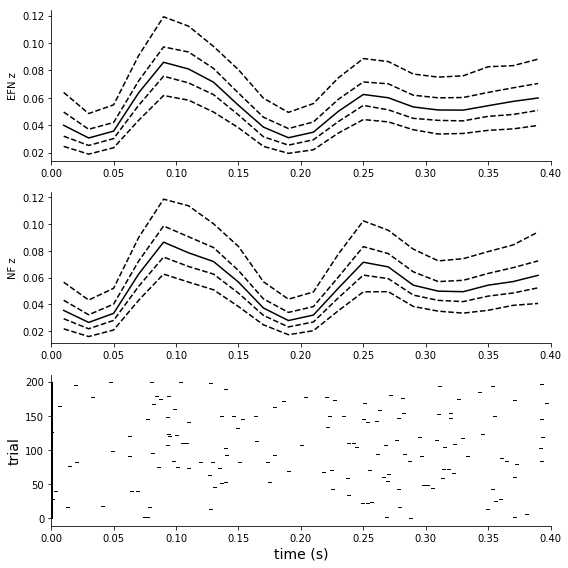

844 monkey 1, neuron 71, ori 5
nf /Users/sbittner/Documents/efn/results/lgc/NF1_log_gaussian_cox_D=20_flow=30P_ds=844_rs=0/
MLE estimate
[0.15  0.115 0.29  0.28  0.195 0.15  0.18  0.08  0.17  0.195 0.27  0.31
 0.175 0.18  0.14  0.09  0.125 0.175 0.2   0.27 ]


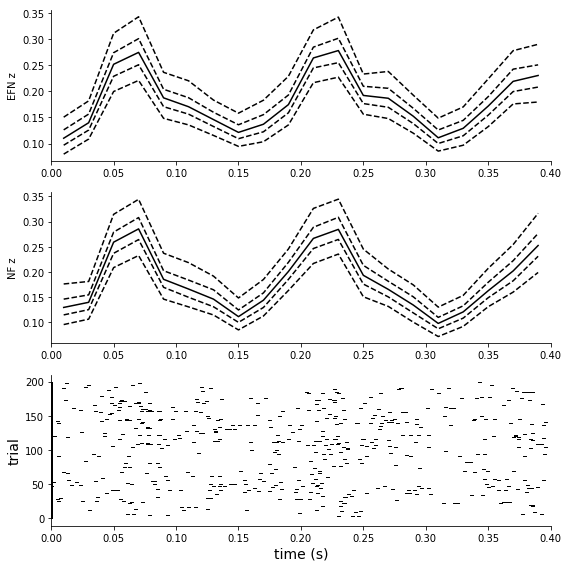

1697 monkey 2, neuron 59, ori 6
nf /Users/sbittner/Documents/efn/results/lgc/NF1_log_gaussian_cox_D=20_flow=30P_ds=1697_rs=0/
MLE estimate
[0.04  0.005 0.035 0.035 0.065 0.025 0.035 0.06  0.06  0.025 0.01  0.05
 0.04  0.045 0.02  0.065 0.06  0.025 0.03  0.07 ]


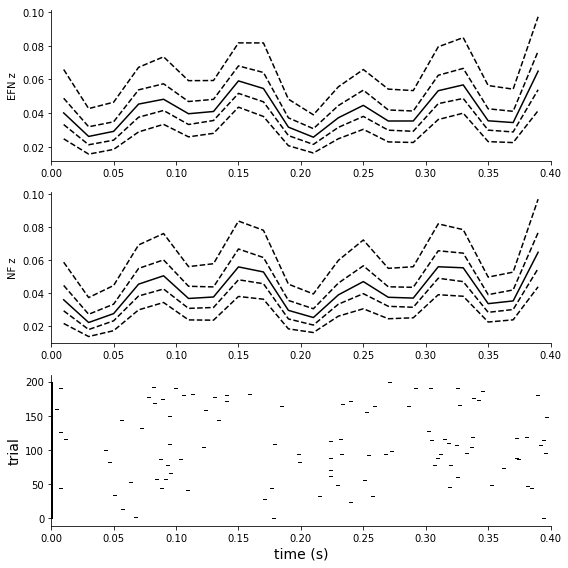

2023 monkey 3, neuron 27, ori 8
nf /Users/sbittner/Documents/efn/results/lgc/NF1_log_gaussian_cox_D=20_flow=30P_ds=2023_rs=0/
MLE estimate
[0.035 0.005 0.005 0.005 0.085 0.51  0.8   0.28  0.025 0.    0.    0.
 0.08  0.45  0.78  0.27  0.035 0.    0.    0.   ]


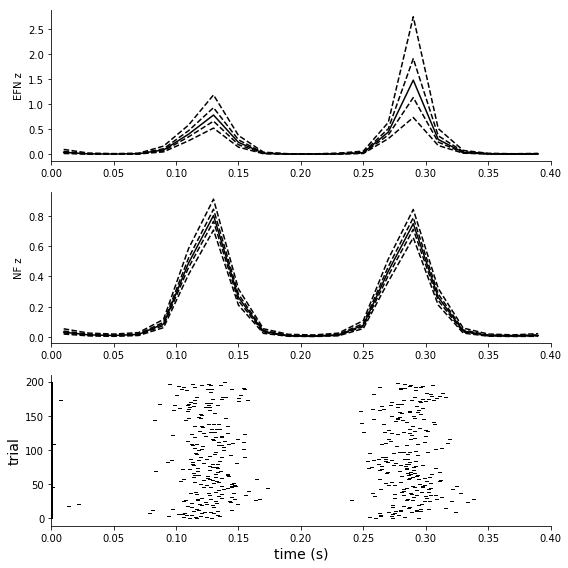

In [4]:

prctiles = [5, 25, 50, 75, 95];
monkey_by_ind, neuron_by_ind, ori_by_ind = easy_inds();
efn_savedir = basedir + setup_IO(family, 'EFN', dir_str, 'eta', K, M, flow_dict, param_net_hps, \
                                             give_hint, rs);
npzfile = np.load(efn_savedir + 'results.npz');
efn_test_X = npzfile['test_X'];
efn_test_params = npzfile['test_params'][()];
for i in range(5):
    efn_Z = np.exp(efn_test_X[i,:,:,0]);
    data_ind = efn_test_params[i]['data_ind'];
    monkey = int(monkey_by_ind[data_ind]);
    neuron = int(neuron_by_ind[data_ind]);    
    ori = int(ori_by_ind[data_ind]);
    print(data_ind, 'monkey %d, neuron %d, ori %d' % (monkey, neuron, ori));
    assert(data_ind == family.resp_info_to_ind({'monkey':monkey, 'neuron':neuron, 'ori':ori}));
    # load NF model
    dist_info = {'dist_seed':data_ind};
    nf_savedir = basedir + setup_IO(family, 'NF1', dir_str, 'eta', 1, M, flow_dict, param_net_hps, \
                                             give_hint, rs, dist_info);
    print('nf', nf_savedir);
    nf_npzfile = np.load(nf_savedir + 'results.npz');
    nf_X = nf_npzfile['X'][0,:,:,0];
    nf_Z = np.exp(nf_X);
    
    # load counts spikes
    counts, spikes = load_counts_spikes(monkey, neuron, ori);
    print("MLE estimate");
    print(np.mean(counts,0)[:D]);
    spikes = cut_trailing_spikes(spikes, D, T_s);
    
    fontsize= 14;
    plt.figure(figsize=(8,8));
    plt.subplot(3,1,1);
    time_series_contour(efn_Z, prctiles, T_s);
    plt.xlim([0.0,D*T_s]);
    plt.ylabel('EFN z');
    ax = plt.gca();
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout();
    
    plt.subplot(3,1,2);
    time_series_contour(nf_Z, prctiles, T_s);
    plt.xlim([0.0,D*T_s]);
    plt.ylabel('NF z');
    ax = plt.gca();
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout();
    
    

    plt.subplot(3,1,3);
    plt.eventplot(np.array(spikes), colors='k', orientation='horizontal', linewidths=4);
    plt.xlabel('time (s)', fontsize=fontsize);
    plt.ylabel('trial', fontsize=fontsize);
    plt.xlim([0.0,D*T_s]);
    ax = plt.gca();
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout();
    plt.show();

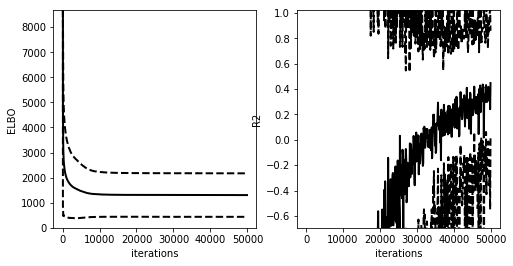

In [4]:
prctiles = [5, 25, 50, 75, 95];
monkey_by_ind, neuron_by_ind, ori_by_ind = easy_inds();
efn_savedir = basedir + setup_IO(family, 'EFN', dir_str, 'eta', K, M, flow_dict, param_net_hps, \
                                             give_hint, rs);
npzfile = np.load(efn_savedir + 'results.npz');

check_rate = npzfile['check_rate'];
test_elbos = npzfile['test_elbos'];
mean_elbos = np.mean(test_elbos, 1);
std_elbos = np.std(test_elbos, 1);

test_R2s = npzfile['train_R2s'];
mean_R2s = np.mean(test_R2s, 1);
std_R2s = np.std(test_R2s, 1);

last_ind = find_last_ind(test_elbos);
#final_ind = find_convergence(mean_elbos, last_ind+1, wsize, delta_thresh);
#if (final_ind is None):
#    print('didnt converge');
#    final_ind = last_ind;
final_ind = 500;
its = np.arange(0, check_rate*final_ind, check_rate);

plt.figure(figsize=(8, 4));
plt.subplot(1,2,1);
plt.plot(its, mean_elbos[:final_ind], 'k', lw=2);
min_val = np.min(mean_elbos[:final_ind]-std_elbos[:final_ind]);
plt.plot(its, mean_elbos[:final_ind]+std_elbos[:final_ind],'k--', lw=2);
plt.plot(its, mean_elbos[:final_ind]-std_elbos[:final_ind],'k--', lw=2);
std_mag = std_elbos[final_ind];
min_val = np.min(mean_elbos);
max_val = min_val + 10*std_mag;
plt.ylim([min_val, max_val]);
plt.xlabel('iterations');
plt.ylabel('ELBO');

plt.subplot(1,2,2);
plt.plot(its, mean_R2s[:final_ind], 'k', lw=2);
min_val = np.min(mean_R2s[:final_ind]-std_R2s[:final_ind]);
plt.plot(its, mean_R2s[:final_ind]+std_R2s[:final_ind],'k--', lw=2);
plt.plot(its, mean_R2s[:final_ind]-std_R2s[:final_ind],'k--', lw=2);
std_mag = std_R2s[final_ind];
max_val = np.max(mean_R2s) + std_mag;
min_val = max_val - 4*std_mag;
plt.ylim([min_val, max_val]);
plt.xlabel('iterations');
plt.ylabel('R2');

plt.show()

In [5]:
model_str_prefix = 'NF1_log_gaussian_cox_D=20_flow=30P'
lgcdir = '/Users/sbittner/Documents/efn/results/lgc/';
dir_list = os.listdir(lgcdir);
num_dir_elems = len(dir_list);
num_models = 0;
model_strs = [];
nits = 0;
for i in range(num_dir_elems):
    model_str_i = dir_list[i];
    if (model_str_prefix in model_str_i):
        model_strs.append(model_str_i)
        fname_i = lgcdir + model_str_i + '/results.npz'
        npzfile = np.load(fname_i);
        train_elbos = npzfile['train_elbos'];
        nits_i = train_elbos.shape[0];
        if (nits_i > nits):
            nits = nits_i;
        num_models += 1;

        
final_ind = 500;

all_train_elbos = np.zeros((num_models, final_ind))
for i in range(num_models):
    fname_i = lgcdir + model_strs[i] + '/results.npz'
    npzfile = np.load(fname_i);
    all_train_elbos[i,:] = npzfile['train_elbos'][:final_ind,0];


In [6]:
mean_train_elbos = np.mean(all_train_elbos, 0);
std_train_elbos = np.std(all_train_elbos, 0);
its = np.arange(0, final_ind*check_rate, check_rate);


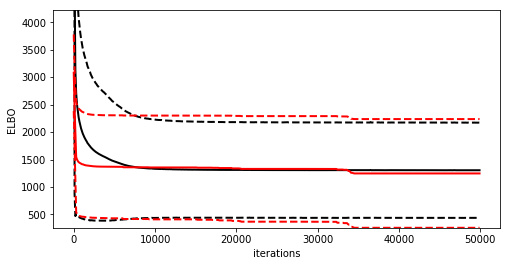

In [7]:
plt.figure(figsize=(8, 4));
plt.plot(its, mean_elbos[:final_ind], 'k', lw=2);
min_val = np.min(mean_elbos[:final_ind]-std_elbos[:final_ind]);
plt.plot(its, mean_elbos[:final_ind]+std_elbos[:final_ind],'k--', lw=2);
plt.plot(its, mean_elbos[:final_ind]-std_elbos[:final_ind],'k--', lw=2);

plt.plot(its, mean_train_elbos[:final_ind], 'r', lw=2);
min_val = np.min(mean_train_elbos[:final_ind]-std_train_elbos[:final_ind]);
plt.plot(its, mean_train_elbos[:final_ind]+std_train_elbos[:final_ind],'r--', lw=2);
plt.plot(its, mean_train_elbos[:final_ind]-std_train_elbos[:final_ind],'r--', lw=2);
std_mag = std_train_elbos[final_ind-1];
min_val = np.min(mean_train_elbos) - std_mag
max_val = min_val + 4*std_mag;
plt.ylim([min_val, max_val]);
plt.xlabel('iterations');
plt.ylabel('ELBO');

In [8]:
mean_efn_elbos = mean_elbos;
mean_nf_elbos = mean_train_elbos;

In [14]:
efn_lgc_dir = '/Users/sbittner/Documents/efn/results/lgc/EFN_log_gaussian_cox_D=20_K=100_M=200_flow=30P_L=5_rs=0/';
npzfile = np.load(efn_lgc_dir + 'profile.npz');
efn_avgtime = np.mean(npzfile['times'][-10:]);

nf_lgc_dir = '/Users/sbittner/Documents/efn/results/lgc/NF1_log_gaussian_cox_D=20_flow=30P_ds=0_rs=0/';
npzfile = np.load(nf_lgc_dir + 'profile.npz');
nf_avgtime = np.mean(npzfile['times'][-10:]);

print('EFN average it', efn_avgtime);
print('NF1 average it', nf_avgtime)

EFN average it 0.1036653995513916
NF1 average it 0.03385097980499267


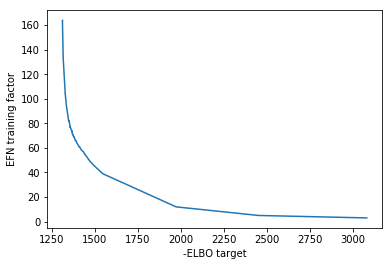

In [16]:
nits = 500;
its = np.arange(nits);
efn_better_its = np.zeros((nits,));
for i in range(nits):
    efn_better_it = np.where(mean_efn_elbos[:final_ind] < mean_nf_elbos[i])[0];
    if (len(efn_better_it) > 0):
        efn_better_its[i] = efn_better_it[0]
    else:
        efn_better_its[i] = np.nan;
plt.figure();
plt.plot(mean_nf_elbos, efn_better_its);
plt.xlabel('-ELBO target');
plt.ylabel('EFN training factor');
plt.show();
    